In [ ]:
%pip install bashlex

In [2]:
import bashlex
import networkx as nx
import uuid

class ShellDiGraphConstructor:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.visited_nodes = set()  # To keep track of visited nodes for cycle detection
        self.step_counter = 0  # Counter to label edges with a step number

    def visit(self, node, parent_id=None, relationship=None):
        if node not in self.visited_nodes:
            self.visited_nodes.add(node)
            kind = node.kind
            handler = getattr(self, f'handle_{kind}', self.handle_generic)
            # Now we pass the relationship parameter to the handler
            return handler(node, parent_id, relationship)
        return None

    def get_node_identifier(self, kind):
        # Now expects a string 'kind', not a node object or dictionary
        return f"{kind}_{uuid.uuid4()}"

    def create_new_node(self, node_type, node_label, parent_id=None, edge_label=None, relationship=None):
        node_id = self.get_node_identifier(node_type)
        self.graph.add_node(node_id, type=node_type, label=node_label)
        if parent_id:
            edge_label = edge_label or f'Step {self.step_counter}: {node_type}_of'
            relationship = relationship or f'{node_type}_of'
            self.graph.add_edge(parent_id, node_id, label=edge_label, relationship=relationship)
            self.step_counter += 1
        return node_id

    def handle_command(self, node, parent_id, relationship=None):
        if not node.parts:
            return None
        # Command may have pipe or logical operators, handle them separately
        if any(part.kind in ['pipe', 'operator'] for part in node.parts):
            return self.handle_complex_command(node, parent_id)
        else:
            command_id = self.create_new_node('command', node.parts[0].word, parent_id, relationship=relationship or 'command_of')
            for part in node.parts[1:]:
                if part.kind == 'word':
                    self.create_new_node('word', part.word, command_id, relationship='argument_of')
            return command_id

        
    def handle_word(self, node, parent_id, relationship=None):
        if node.word.startswith('$(') and node.word.endswith(')'):
            # This is a command substitution
            command_substitution_id = self.create_new_node('command_substitution', node.word, parent_id, relationship='command_substitution_of')
            # Parse the content inside the command substitution
            parts = bashlex.parse(node.word[2:-1])
            for part in parts:
                self.visit(part, command_substitution_id, relationship='part_of')
            return command_substitution_id
        else:
            # For a simple word, the relationship may be the one passed in, such as 'argument_of'
            return self.create_new_node('word', node.word, parent_id, relationship=relationship)
    
    def handle_subshell(self, node, parent_id, relationship=None):
        subshell_id = self.create_new_node('subshell', 'subshell', parent_id, relationship='subshell_of')
        for part in node.parts:
            self.visit(part, subshell_id, relationship='part_of')
        return subshell_id

    def handle_backticks(self, node, parent_id, relationship=None):
        backticks_id = self.create_new_node('backticks', 'backticks', parent_id, relationship='backticks_of')
        for part in node.parts:
            self.visit(part, backticks_id, relationship='part_of')
        return backticks_id


    def handle_complex_command(self, node, parent_id):
        complex_command_id = self.create_new_node('complex_command', 'complex', parent_id)
        current_id = complex_command_id
        for part in node.parts:
            if part.kind in ['pipe', 'operator']:
                operator_id = self.create_new_node(part.kind, part.word, complex_command_id)
                current_id = operator_id  # Set current id to the operator for the next command to connect to
            else:
                # Connect the command or word to the last operator or the complex_command itself
                self.visit(part, current_id)
        return complex_command_id

    def handle_compound(self, node, parent_id, relationship=None):
        compound_id = None
        if not hasattr(node, 'list'):
            return None
        for inner_node in node.list:
            # Now pass the relationship to the recursive visit call
            compound_id = self.visit(inner_node, parent_id, relationship)
        return compound_id

    def handle_generic(self, node, parent_id, relationship=None):
        if hasattr(node, 'parts'):
            for part in node.parts:
                # Now pass the relationship to the recursive visit call
                self.visit(part, parent_id, relationship)
    
    def handle_for(self, node, parent_id, relationship=None):
        for_id = self.create_new_node('for', 'for', parent_id, relationship='for_of')
        for part in node.parts:
            if part.kind == 'word':
                self.create_new_node('variable', part.word, for_id, relationship='variable_of')
            elif part.kind == 'compound':
                self.visit(part, for_id, relationship='body_of')
        return for_id


    def handle_while(self, node, parent_id, relationship=None):
        while_id = self.create_new_node('while', 'while', parent_id, relationship='while_of')
        for part in node.parts:
            if part.kind == 'command':
                # The condition of the while loop
                self.visit(part, while_id, relationship='condition_of')
            elif part.kind == 'compound':
                # The body of the while loop
                self.visit(part, while_id, relationship='body_of')
        return while_id

    def handle_if(self, node, parent_id, relationship=None):
        if_id = self.create_new_node('if', 'if', parent_id, relationship='if_of')
        for part in node.parts:
            if part.kind == 'command':
                # The condition of the if statement
                self.visit(part, if_id, relationship='condition_of')
            elif part.kind == 'compound':
                # The body of the if statement
                self.visit(part, if_id, relationship='body_of')
        return if_id


def parse_shell_script(script):
    parts = bashlex.parse(script)
    digraph_constructor = ShellDiGraphConstructor()
    for part in parts:
        digraph_constructor.visit(part)
    return digraph_constructor.graph




In [4]:
launchchess_example = """
#!/bin/bash
VERSION=0.1.0
if [ $1 = "version" -o $1 = "v" -o $1 = "-v" ]; then
  echo $VERSION

elif [ $1 = "init" ]; then
  # install pip and npm requirements
  shift
  pip install -r requirements.txt
  docker run -it -v $(pwd)/web:/app -w /app node yarn install "$@"

elif [ $1 = "install" -o $1 = "i" ]; then
  # add a new package
  shift
  docker run -it -v $(pwd)/web:/app -w /app node yarn add "$@"

elif [ $1 = "build" ]; then
  # build js files, no dev server
  shift
  docker run -it -v $(pwd)/web:/app -w /app -p 5555:5555 node yarn parcel watch --port 5555 --no-cache --dist-dir dist src/index.html

elif [ $1 = "dev" ]; then
  # start dev server (no https)
  shift
  docker run -it -v $(pwd)/web:/app -w /app -p 5555:5555 node yarn parcel --port 5555 --no-cache --dist-dir dist src/index.html

elif [ $1 = "run" || $1 =~ "serve" ]; then
  # run local https server
  shift
  # uvicorn --reload --host 0.0.0.0 --port 5000 api:app
  uvicorn api:app --port 9999 --ssl-keyfile=./testcert-key.pem --ssl-certfile=./testcert.pem --reload

elif [ $1 = "prod" || $1 = "production" || $1 = "p" ]; then
  # run production image
  shift
  docker-compose down
  docker run -it -v $(pwd)/web:/app -w /app node yarn parcel build --no-cache --dist-dir dist src/index.html
  docker-compose up -d --build "$@"

elif [ $1 = "cert" ]; then
  # generate a new self-signed certificate
  shift
  openssl req -x509 -newkey rsa:4096 -nodes -keyout testcert-key.pem -out testcert.pem -sha256 -days 365 && \
  echo "Successfully generated certfiles!"

fi
"""

In [5]:
alfred_example = """
#!/bin/sh

# Returns a greeting quote to the user.
echo
shuf -n 1 quotes.csv
echo

downloadMedia() {
  echo "downloading demo media"
  mkdir -p videos && cd videos
  wget -N https://storage.googleapis.com/tower-bucket/moon.mp4
  wget -N https://storage.googleapis.com/tower-bucket/train.mp4
  wget -N https://storage.googleapis.com/tower-bucket/ATripToTheMoon-300k.mp4
  wget -N https://storage.googleapis.com/tower-bucket/TheGreatTrainRobbery-300k.mp4
  cd ..
}

if [ -z $1 ]; then
  echo "$HELP"

elif [ $1 = "version" -o $1 = "v" -o $1 = "-v" ]; then
  echo $VERSION

elif [ $1 = "b" -o $1 = "build" ]; then
  echo "Building docker image"
  shift
  docker compose -f docker-compose.yml -f dev.yml build "$@"

# Starts in development (optional "--build")
elif [ $1 = "d" ] || [ $1 = "dev" ]; then
  if [ !-z ]; then shift; fi
  echo "Alfred! running dev $1"
  docker compose -f docker-compose.yml -f dev.yml up "$@"

# Starts in production.
elif [ $1 = "p" -o $1 = "production" -o $1 = "prod" ]; then
  shift
  echo "Alfred! running production $1"
  docker compose down && \
  docker run --rm -it -v ${PWD}:/docs -v ${PWD}/alfred/site/:/site/ --user $(id -u):$(id -g) squidfunk/mkdocs-material build -d /site/ && \
  docker compose -f docker-compose.yml -f production.yml up --build -d $1

# Installs website dependencies.
elif [ $1 = "init" ]; then
  shift
  mkdir -p $(dirname $0)/website/dist
  mkdir -p $(dirname $0)/alfred/videos
  mkdir -p $(dirname $0)/alfred/data
  mkdir -p $(dirname $0)/alfred/site
  echo "installing dependencies"
  docker compose run website yarn install

  # Installs the dependencies.
elif [ $1 = "i" -o $1 = "install" ]; then
    shift
    echo "installing dependencies"
    # make install
    docker compose -f docker-compose.yml run website yarn add "$@"

elif [ $1 = "demo" -o $1 = "download" -o $1 = "samples" ]; then
  shift
  downloadMedia

elif [ $1 = "restart" -o $1 = "r" ]; then
  shift
  docker compose -f docker-compose.yml -f production.yml restart

elif [ $1 = "seed" -o $1 = "db" ]; then
  shift
  docker compose exec api python3.10 -c \"""
from seed import seed
from db import db

if db.projects.count_documents({}) == 0:
  db.projects.insert_many(seed)
\"""

elif [ $1 = "reinit" -o $1 = "reseed" ]; then
  shift
  docker compose -f docker-compose.yml -f dev.yml exec api python3.10 -c \"""
from seed import seed
from alfred.core.utils import get_sync_db
db = get_sync_db()
db.Project.drop()
db.Project.insert_many(seed)
\"""

elif [ $1 = "sh" ]; then
  shift
  docker compose -f docker-compose.yml -f dev.yml exec api sh "$@"

elif [ $1 = "l" -o $1 = "logs" -o $1 = "log" ]; then
  shift
  docker compose logs -f "$@"

elif [ $1 = "w" -o $1 = "worker" ]; then
  shift
  # . operator used in place of source
  . ./.cred
  # DB_URL=mongodb://$1:27017 CELERY_BROKER=$DB_URL/celery CELERY_BACKEND=$CELERY_BROKER celery -A tasks:renderer --workdir alfred/ -b $CELERY_BROKER --result-backend $CELERY_BACKEND worker --concurrency=4
  DB_URL=mongodb://$1:27017 DB_NAME=alfred CELERY_BROKER=$DB_URL/celery CELERY_BACKEND=$CELERY_BROKER celery -A alfred.core.utils:renderer --workdir alfred/ worker --concurrency=4
  # docker compose -f docker-compose.yml -f dev.yml run -it --entrypoint "celery -A alfred.core.utils.tasks:renderer --workdir /app/alfred -b mongodb://$1:27017/celery --result-backend mongodb://$1:27017/celery worker --loglevel=debug --concurrency=1" renderer

elif [ $1 = "dump" ]; then
  shift
  DATE=`date "+%Y-%m-%d-%H%M%S"`
  FILENAME=alfred_db_$DATE.gz
  docker compose exec db sh -c "mongodump --db alfred --gzip --archive=$FILENAME"
  docker container cp alfred_db_1:$FILENAME $FILENAME

elif [ $1 = "restore" ]; then
  shift
  docker container cp $1 alfred_db_1:/$1
  docker compose exec db sh -c "mongorestore --gzip --db alfred --archive=/$1 --drop"

elif [ $1 = "reload" ]; then
  shift
  # reload otto
  docker compose -f docker-compose.yml -f dev.yml up -d --build api

elif [ $1 = "g" -o $1 = "git" ]; then
  shift
  git pull && git submodule update

elif [ $1 = "docs" -o $1 = "doc" ]; then
  # build documentation and serve locally, with hot reloader
  shift
  mkdocs serve -a 0.0.0.0:4000

elif [ $1 = "docker" -o $1 = "dock" ]; then
  shift
  docker compose -f docker-compose.yml -f dev.yml "$@"

elif [ $1 = "t" -o $1 = "test" -o $1 = "cy" ]; then
  shift
  docker compose -f test_cy.yml up --exit-code-from cy "$@"

elif [ $1 = "pt" -o $1 = "pytest" -o $1 = "py" ]; then
  shift
  docker compose -f pytest.yml up --exit-code-from pytest "$@"

elif [ $1 = "n" -o $1 = "nox" ]; then
  shift
  nox -f tests/noxfile.py "$@"

elif [ $1 = "bats" -o $1 = "bat" ]; then
  shift
  docker compose -f test_bats.yml up --build --exit-code-from bats "$@"

else
  echo "Unknown command: $1"
  echo "Error when running $@"
  echo "$HELP"

fi
"""

In [ ]:
from pprint import pprint

# Example usage
script_content = """
for i in 1 2 3; do
  echo $i
done

while read line; do
  echo $line
done < file.txt

if [ $1 -gt 100 ]; then
  echo "Greater than 100."
elif [ $1 -eq 100 ]; then
  echo "Equal to 100."
else
  echo "Less than 100."
fi
"""

# graph = parse_shell_script(script_content)
graph = parse_shell_script(alfred_example)
# graph = parse_shell_script(launchchess_example)


json_graph = nx.node_link_data(graph)


pprint(json_graph)

In [7]:
import numpy as np
import networkx as nx

def logical_layout(G, pos=None, dim=2, distance_scale=1.0, k=0.1, iterations=50):
    if pos is None:
        pos = nx.spring_layout(G, dim=dim, k=k, iterations=iterations)
    else:
        pos = {i: np.array(p[:dim]) for i, p in pos.items()}

    epsilon = 1e-9  # Small value to prevent division by zero

    # Compute the distance to the parent node for each node
    parent_distances = {}
    for node in G.nodes():
        parent = list(G.predecessors(node))
        if parent:
            parent_pos = pos[parent[0]]
            node_pos = pos[node]
            distance = np.linalg.norm(node_pos - parent_pos) + epsilon
            parent_distances[node] = distance

    # Scale the distance to the parent node by the distance_scale parameter
    parent_distances = {node: distance_scale * distance for node, distance in parent_distances.items()}

    # Apply the custom layout
    for _ in range(iterations):
        for i in G.nodes():
            if i not in pos:
                continue
            pos_i = pos[i]
            delta = np.zeros(dim)
            for j in G.neighbors(i):
                if j not in pos:
                    continue
                pos_j = pos[j]
                distance = np.linalg.norm(pos_i - pos_j) + epsilon
                if distance == 0:
                    continue  # Skip if distance is zero to prevent division by zero
                if i in parent_distances:
                    distance += parent_distances[i]
                delta += (pos_i - pos_j) * (1 - k * k / (distance * distance))
            pos[i] += delta

    # Sort nodes by their position on the x-axis
    sorted_nodes = sorted(pos.keys(), key=lambda x: pos[x][0])

    # Assign y-coordinates based on the order of the nodes
    y_positions = np.linspace(0, 1, len(sorted_nodes))
    for i, node in enumerate(sorted_nodes):
        pos[node][1] = y_positions[i]

    return pos



In [8]:
def hierarchical_layout(G, roots=None, width=1.0, vert_gap=0.2, xcenter=0.5):
    """
    Place nodes in a hierarchy layout reflecting their level and order.

    G: NetworkX graph
    roots: list of root nodes (each root corresponds to a tree in the forest)
    width: horizontal space allocated for drawing
    vert_gap: vertical gap between levels of the hierarchy
    xcenter: x-coordinate for the root node
    """
    if roots is None:
        # Identify the roots of each connected component
        roots = [n for n, d in G.in_degree() if d == 0]

    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, xcenter=0.5, ytop=1, pos=None, parent=None, parsed=[]):
        if pos is None:
            pos = {root: (xcenter, ytop)}
        else:
            pos[root] = (xcenter, ytop)
        neighbors = list(G.neighbors(root))
        if neighbors:
            # Adjust the horizontal space for the children nodes
            dx = width / len(neighbors) 
            nextx = xcenter - width/2 - dx/2
            for neighbor in neighbors:
                nextx += dx
                pos = _hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap, 
                                     xcenter=nextx, ytop=ytop - vert_gap, pos=pos, parent=root, parsed=parsed)
        return pos

    pos = {}
    y_offset = 0
    for root in roots:
        pos.update(_hierarchy_pos(G, root, width, vert_gap, xcenter, ytop=1-y_offset, pos=pos))
        y_offset += vert_gap  # Offset for next root's y position

    # Horizontal offset for nodes at the same depth
    depth = {}
    for v in G.nodes():
        if v not in pos:
            continue
        d = pos[v][1]
        if d in depth:
            depth[d].append(v)
        else:
            depth[d] = [v]

    for d in depth:
        nodes_at_same_depth = depth[d]
        nodes_at_same_depth.sort(key=lambda v: pos[v][0])  # Sort nodes by their x position
        node_width = width / max(1, (len(nodes_at_same_depth) - 1))
        for i, v in enumerate(nodes_at_same_depth):
            pos[v] = (xcenter - (width/2) + i * node_width, pos[v][1])  # Offset each node horizontally

    return pos


In [9]:
import matplotlib.pyplot as plt

def plot_networkx_graph(graph, layout='spring', scale=1, figsize=(12, 12)):
    # Set the size of the plot
    plt.figure(figsize=figsize)
    pos = {
        'spring': lambda g: nx.spring_layout(g, scale=scale),
        'circular': nx.circular_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spectral': nx.spectral_layout,
        'kamada_kawai': lambda g: nx.kamada_kawai_layout(g, scale=scale),
        'planar': nx.planar_layout,
        'spiral': nx.spiral_layout,
        'logical': lambda g: logical_layout(g),
        'hierarchical': lambda g: hierarchical_layout(g),
    }.get(layout, nx.spring_layout)(graph)
    
    node_color_map = {
        'command': 'skyblue', 
        'argument': 'lightgreen', 
        'operator': 'salmon', 
        'subshell': 'violet',
        'for': 'orange',
        'while': 'pink',
        'if': 'lightblue',
        'condition': 'yellow',
        'variable': 'lightgrey'
    }
    node_shape_map = {
        'command': 'o',  # circle
        'argument': 's',  # square
        'operator': '^',  # triangle up
        'subshell': 'v',  # triangle down
        'for': '>',  # triangle right
        'while': '<',  # triangle left
        'if': 'd',  # diamond
        'condition': 'p',  # pentagon
        'variable': 'h'  # hexagon
    }
    node_size_map = {
        'command': 500, 
        'argument': 500, 
        'operator': 500, 
        'subshell': 500,
        'for': 500,
        'while': 500,
        'if': 500,
        'condition': 500,
        'variable': 500
    }
    edge_color_map = {
        'argument_of': 'green', 
        'body_of': 'red', 
        'pipe_of': 'blue', 
        'operator_of': 'purple',
        'condition_of': 'orange',
        'variable_of': 'grey'
    }
    edge_width_map = {
        'argument_of': 1.0, 
        'body_of': 2.0, 
        'pipe_of': 3.0, 
        'operator_of': 2.5,
        'condition_of': 2.0,
        'variable_of': 1.5
    }

    default_node_color = 'grey'
    default_node_size = 100
    default_edge_color = 'black'
    default_edge_width = 1.0

    edge_colors = [edge_color_map.get(graph.edges[edge].get('relationship'), default_edge_color) for edge in graph.edges()]
    edge_widths = [edge_width_map.get(graph.edges[edge].get('relationship'), default_edge_width) for edge in graph.edges()]

    
    # Draw nodes by shape
    for node_type, shape in node_shape_map.items():
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=[node for node in graph.nodes() if graph.nodes[node].get('type') == node_type],
            node_color=[node_color_map.get(graph.nodes[node].get('type'), default_node_color) for node in graph.nodes() if graph.nodes[node].get('type') == node_type],
            node_size=[node_size_map.get(graph.nodes[node].get('type'), default_node_size) for node in graph.nodes() if graph.nodes[node].get('type') == node_type],
            node_shape=shape
        )


    
    nx.draw_networkx_labels(graph, pos, labels={node: graph.nodes[node]['label'] for node in graph.nodes()}, font_size=12)
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=edge_widths)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): graph.edges[u, v]['label'] for u, v in graph.edges()}, font_size=10)

    plt.show()


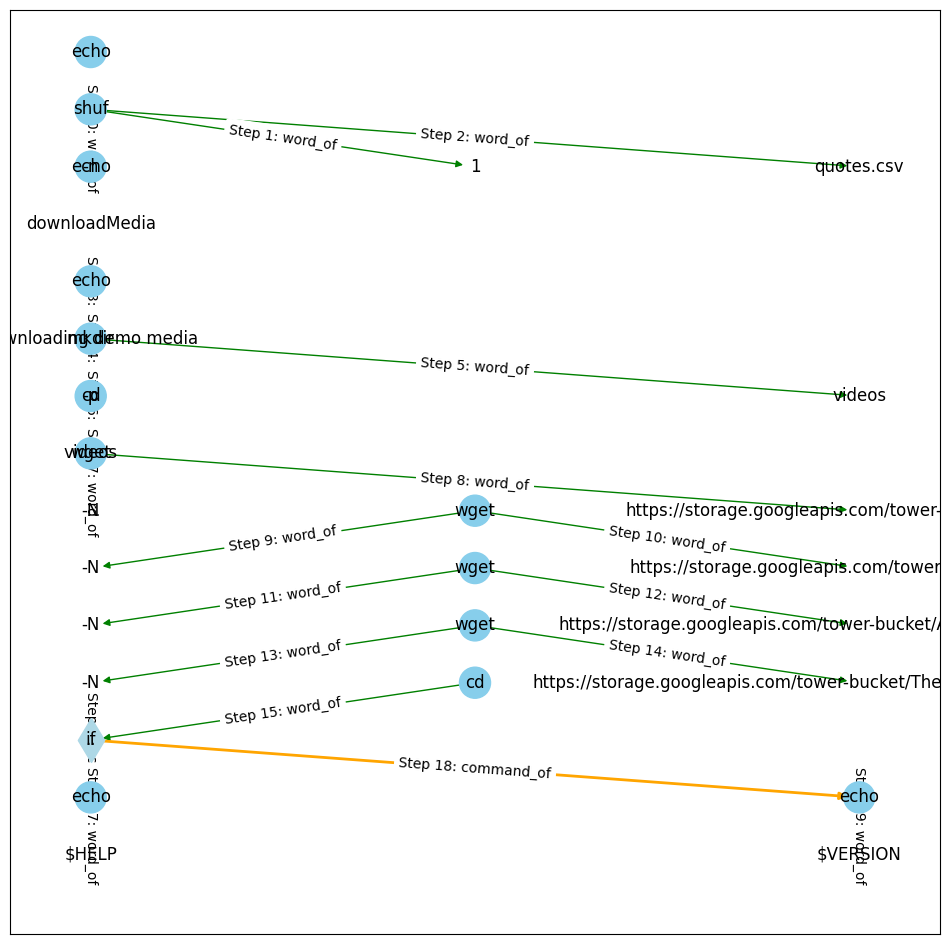

In [10]:
plot_networkx_graph(graph, layout='hierarchical')

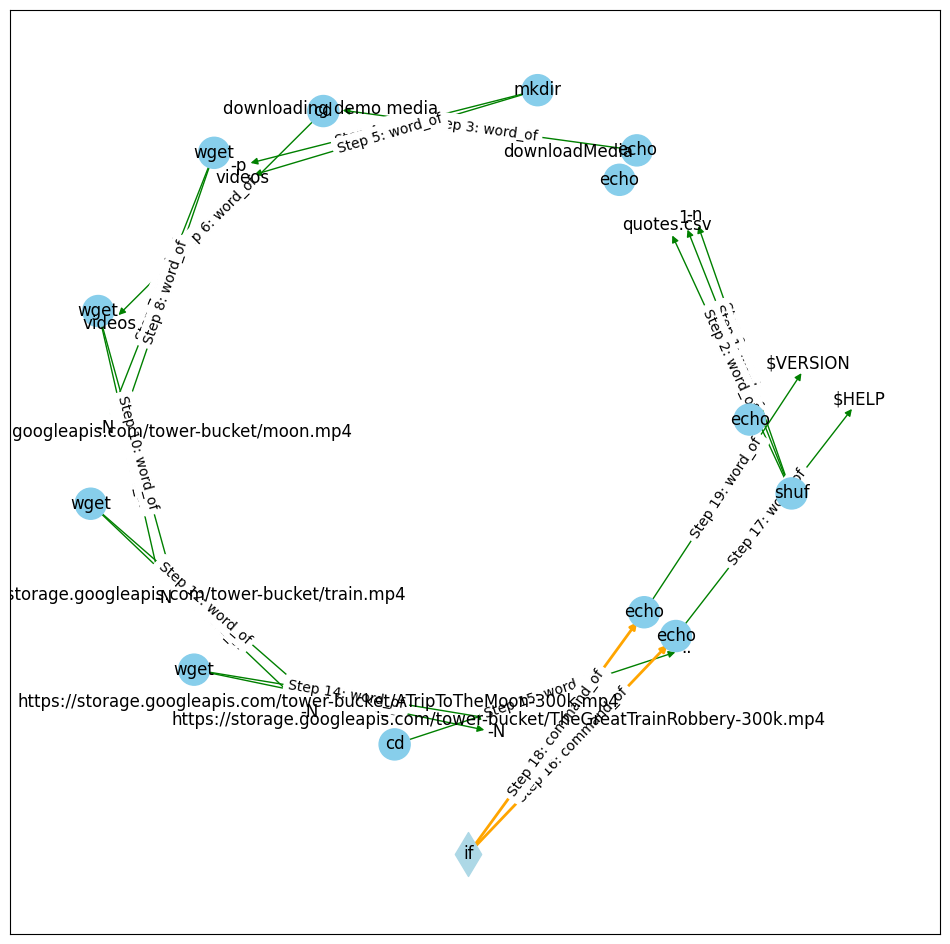

In [11]:
# Call the function with different layouts
plot_networkx_graph(graph, layout='kamada_kawai')

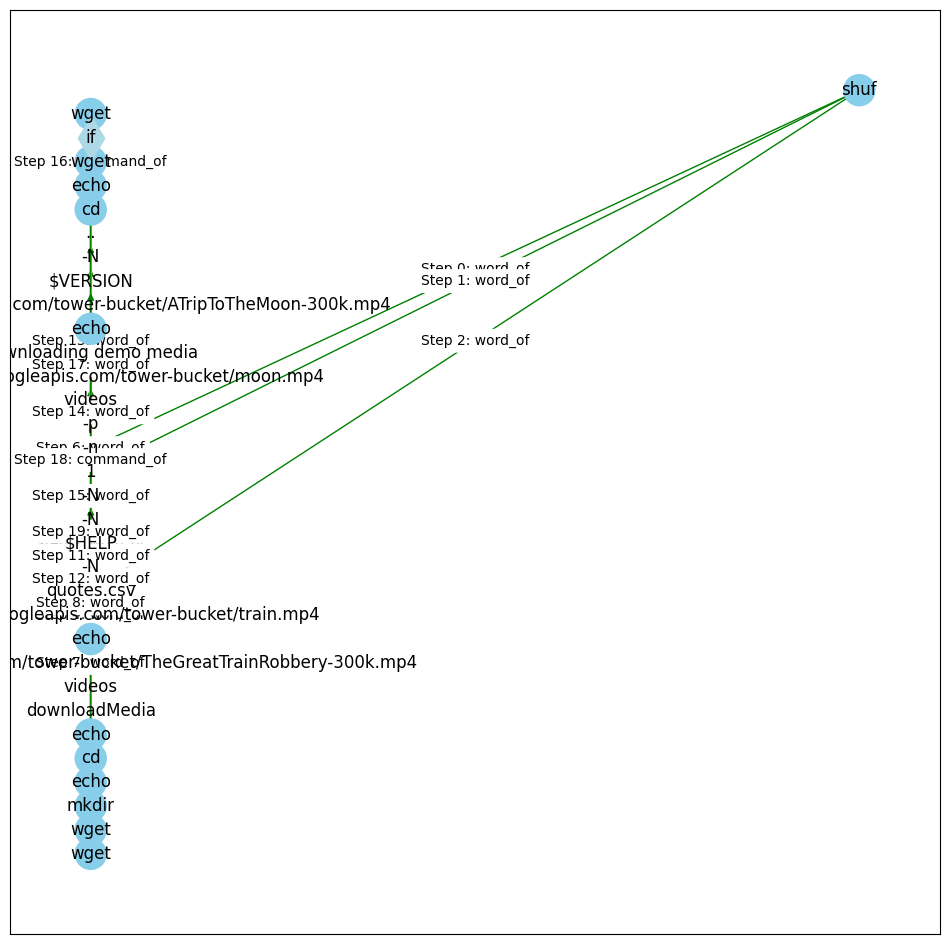

In [12]:
plot_networkx_graph(graph, layout='logical')

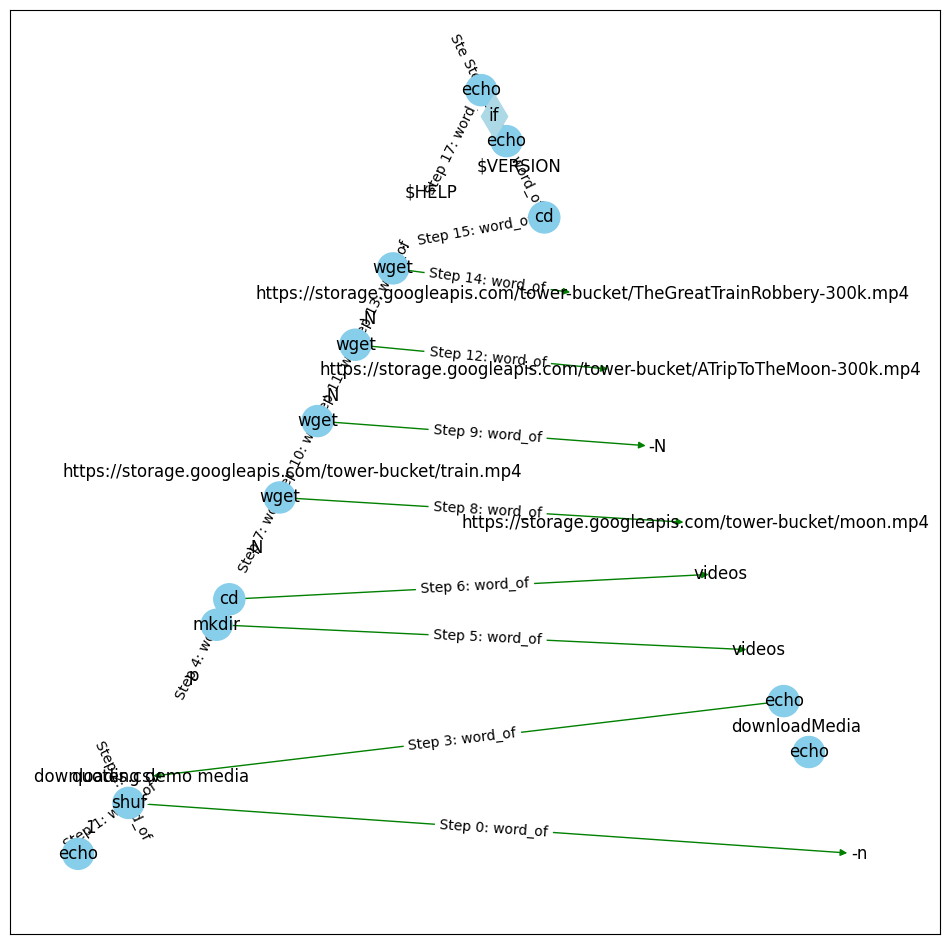

In [13]:
plot_networkx_graph(graph, layout='planar')

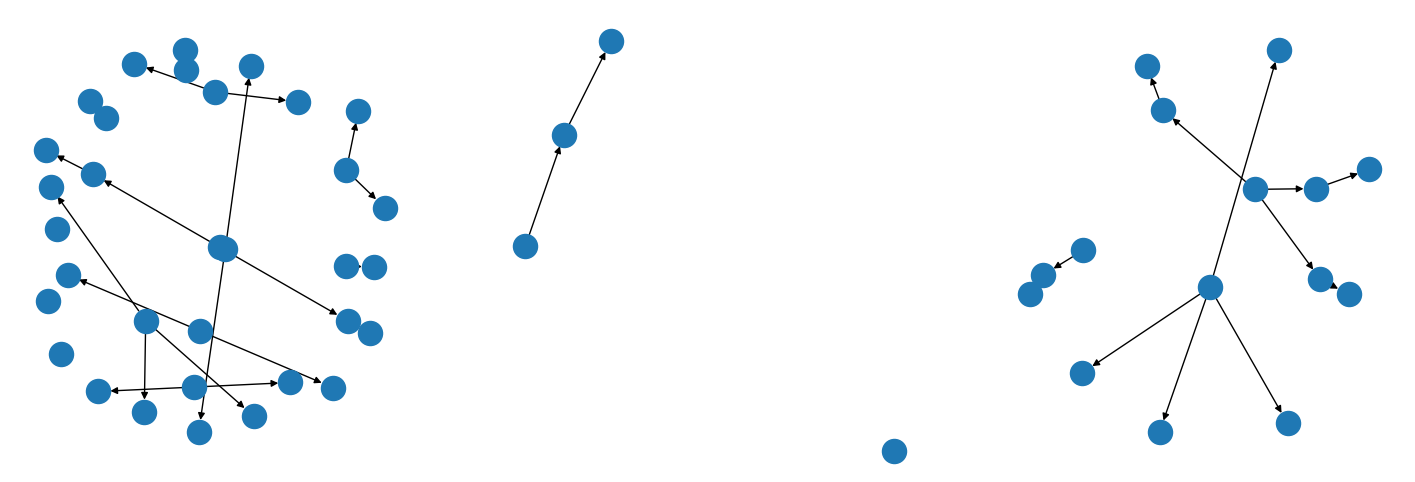

In [14]:
import matplotlib.pyplot as plt

g1 = parse_shell_script(alfred_example)
g2 = parse_shell_script(launchchess_example)
g3 = parse_shell_script(script_content)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
nx.draw(g1, ax=ax[0])
nx.draw(g2, ax=ax[1])
nx.draw(g3, ax=ax[2])
plt.show()

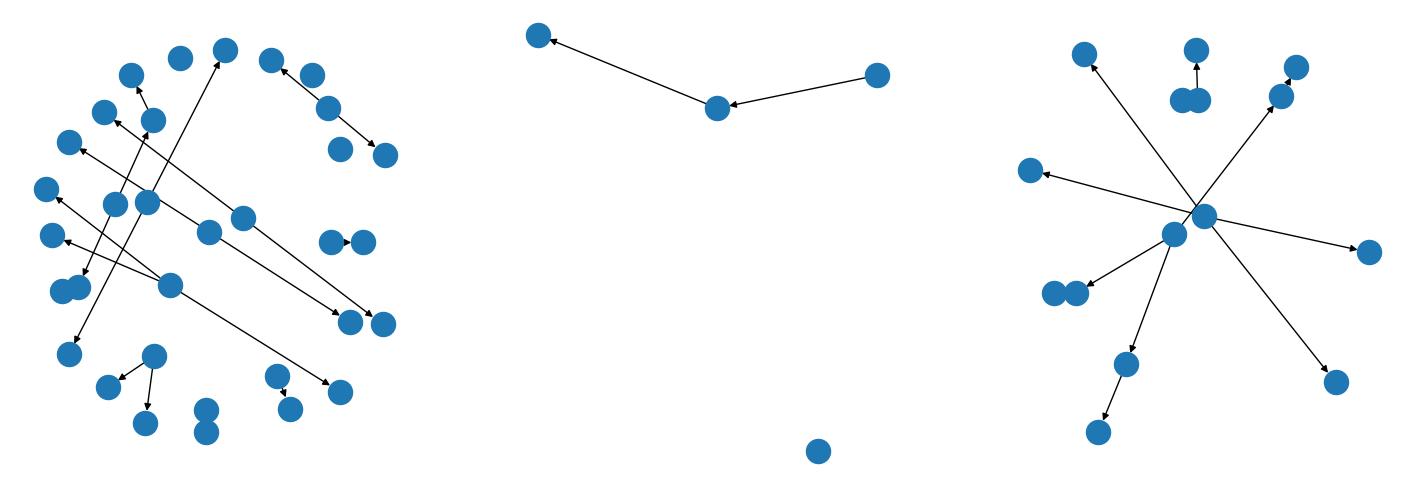

In [15]:
import matplotlib.pyplot as plt

g1 = parse_shell_script(alfred_example)
g2 = parse_shell_script(launchchess_example)
g3 = parse_shell_script(script_content)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
nx.draw(g1, ax=ax[0])
nx.draw(g2, ax=ax[1])
nx.draw(g3, ax=ax[2])
plt.show()

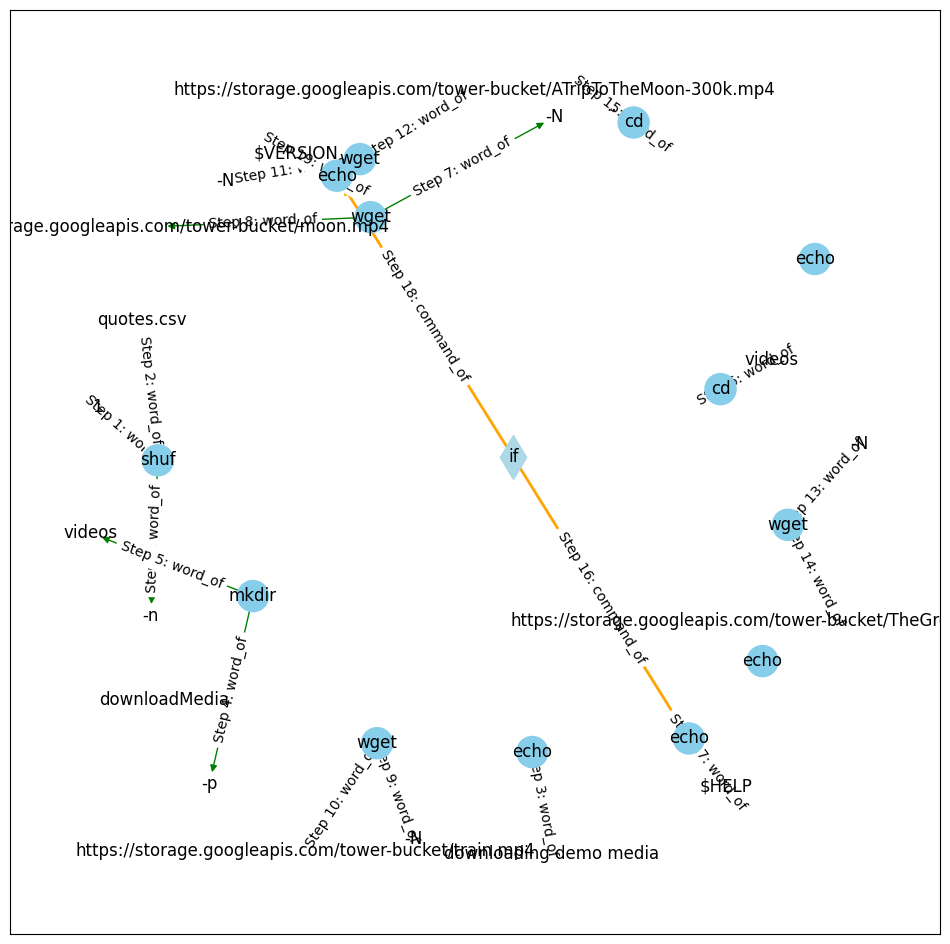

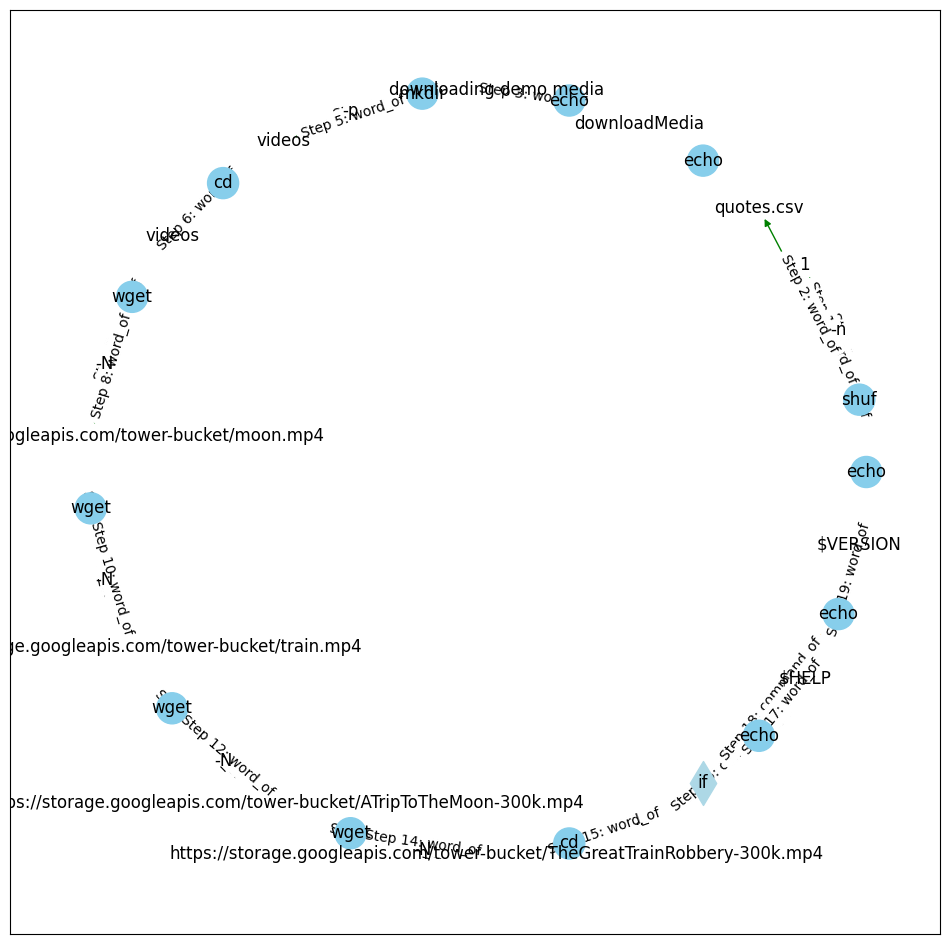

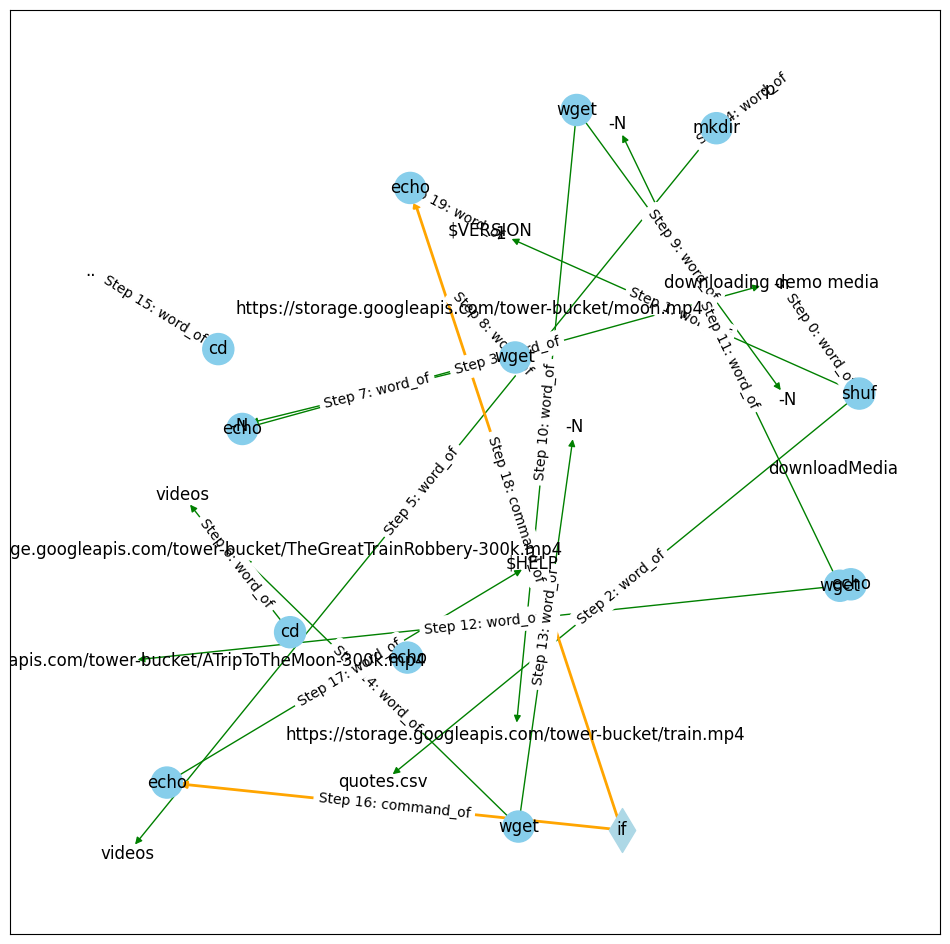

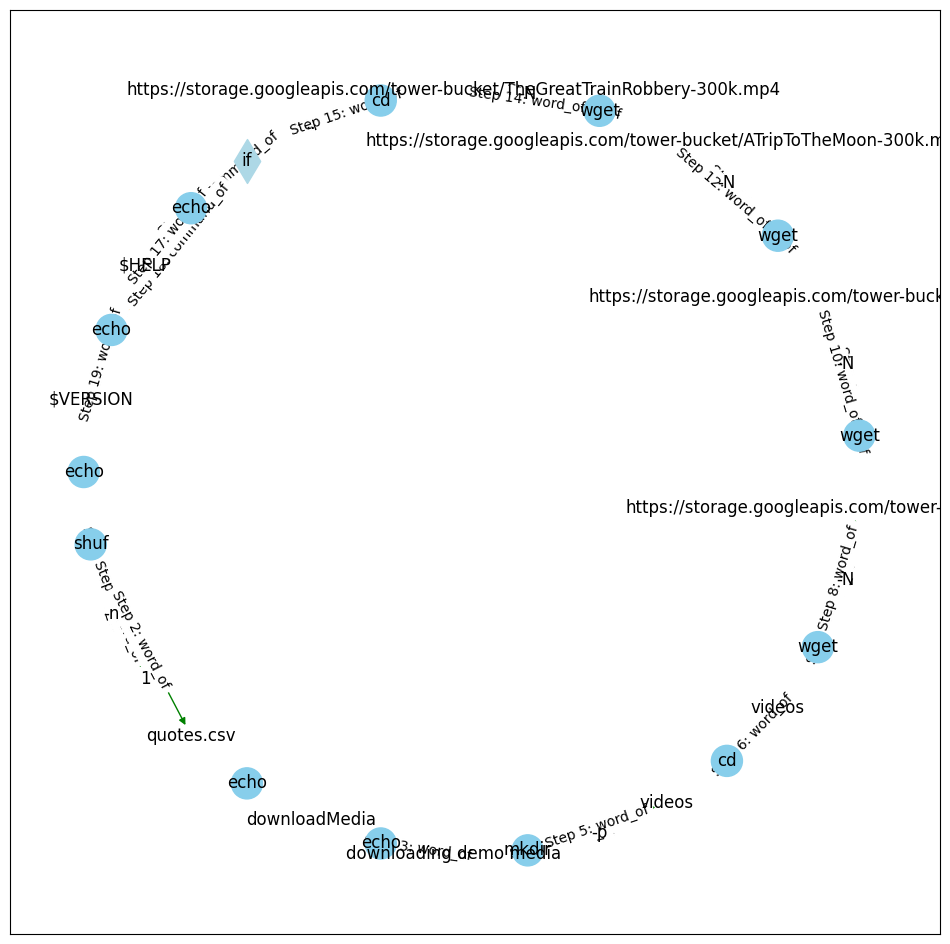

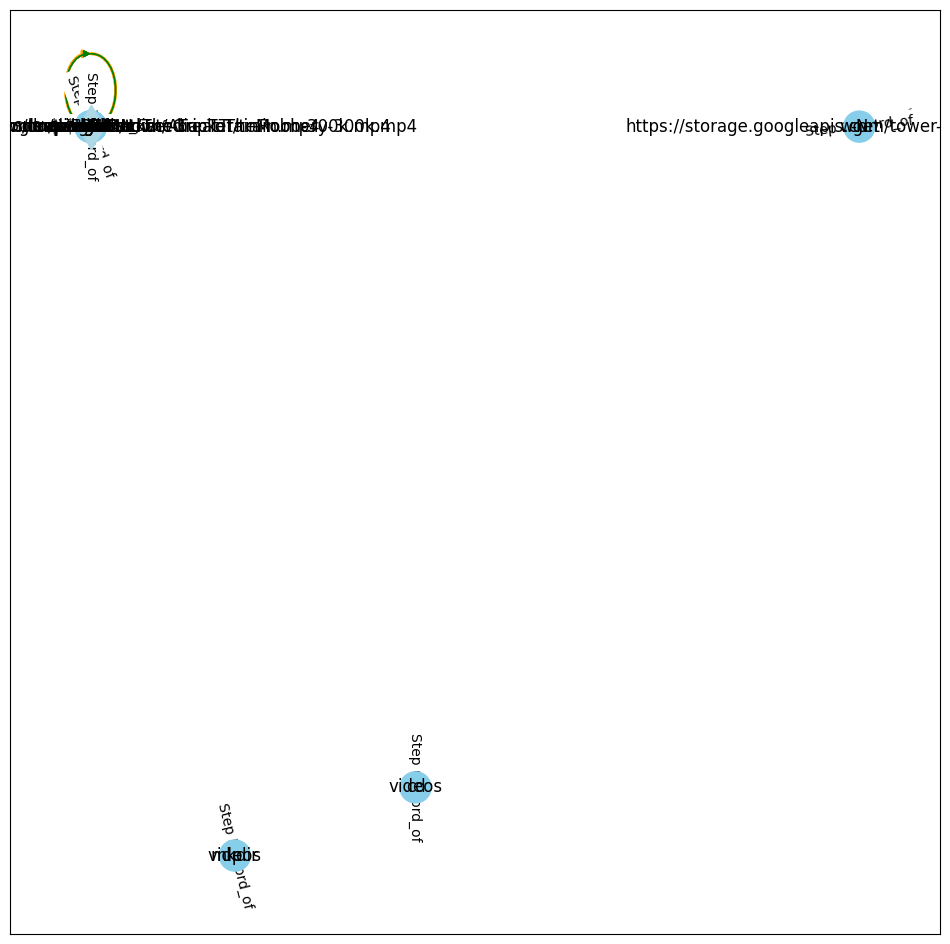

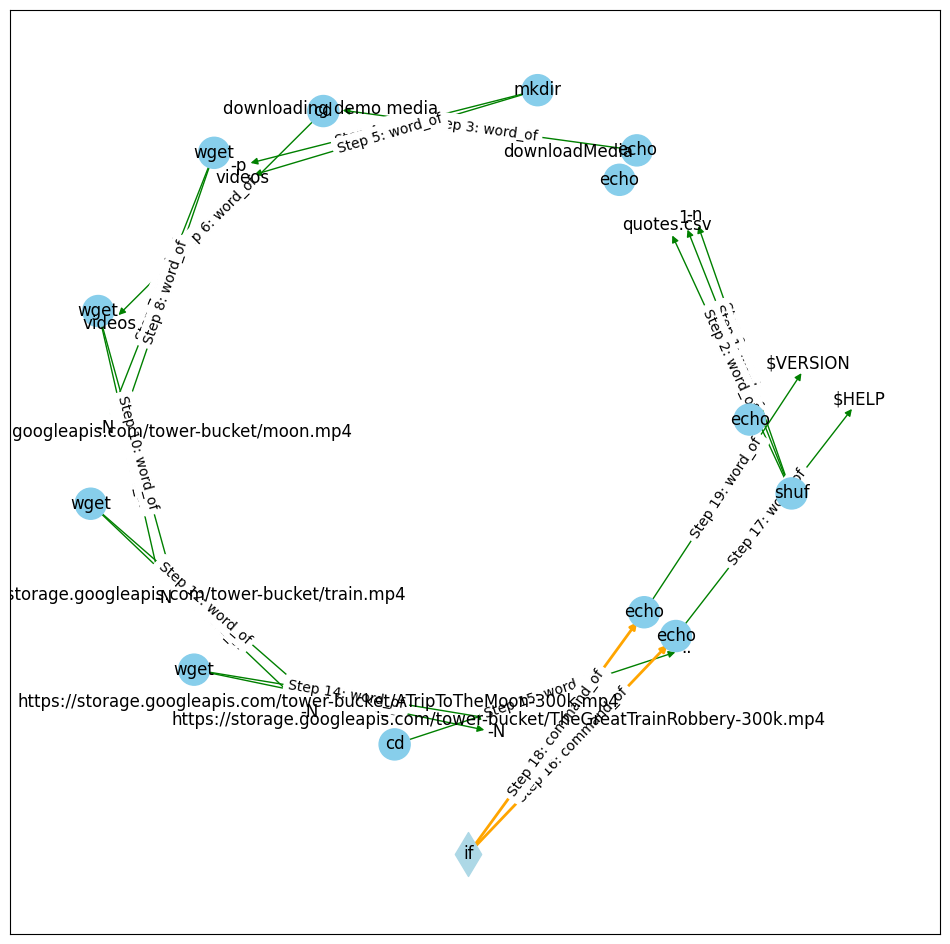

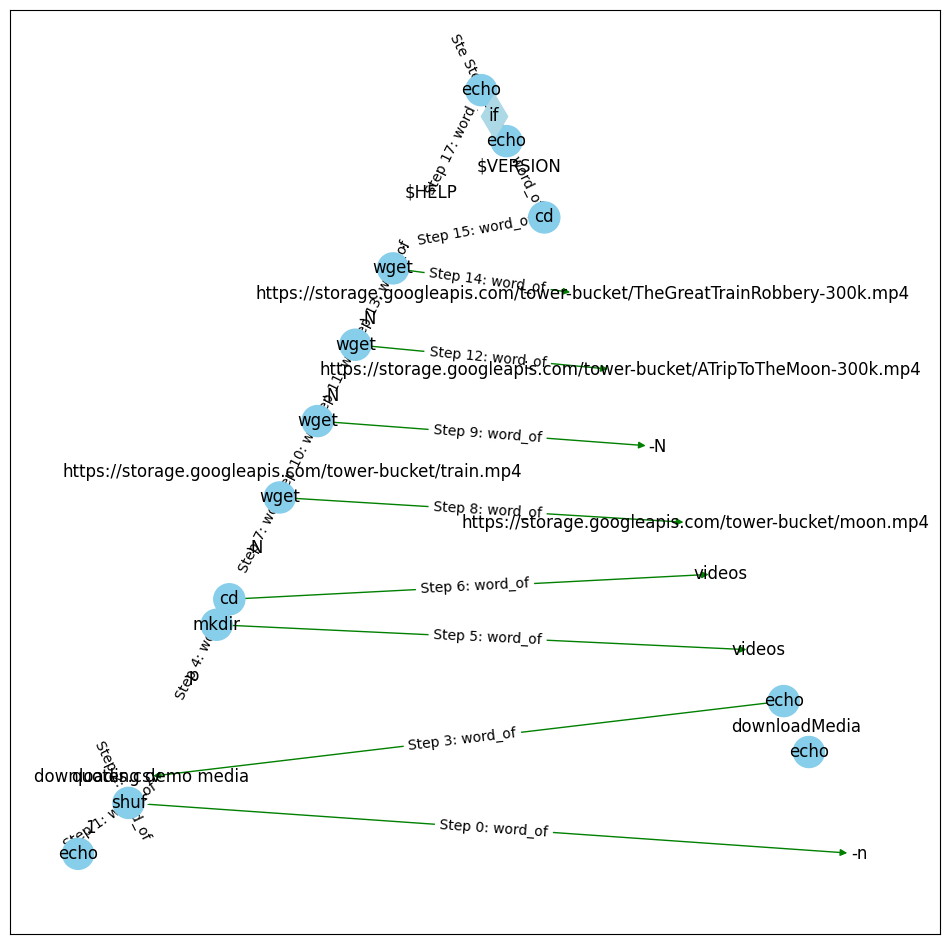

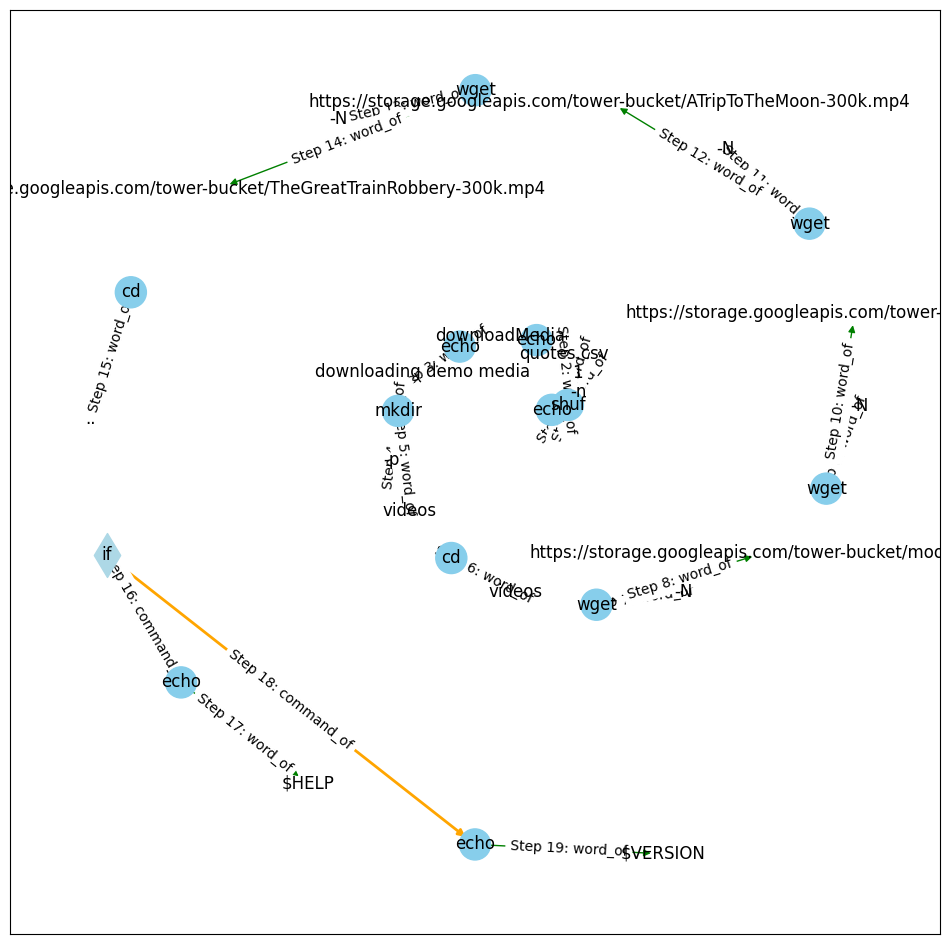

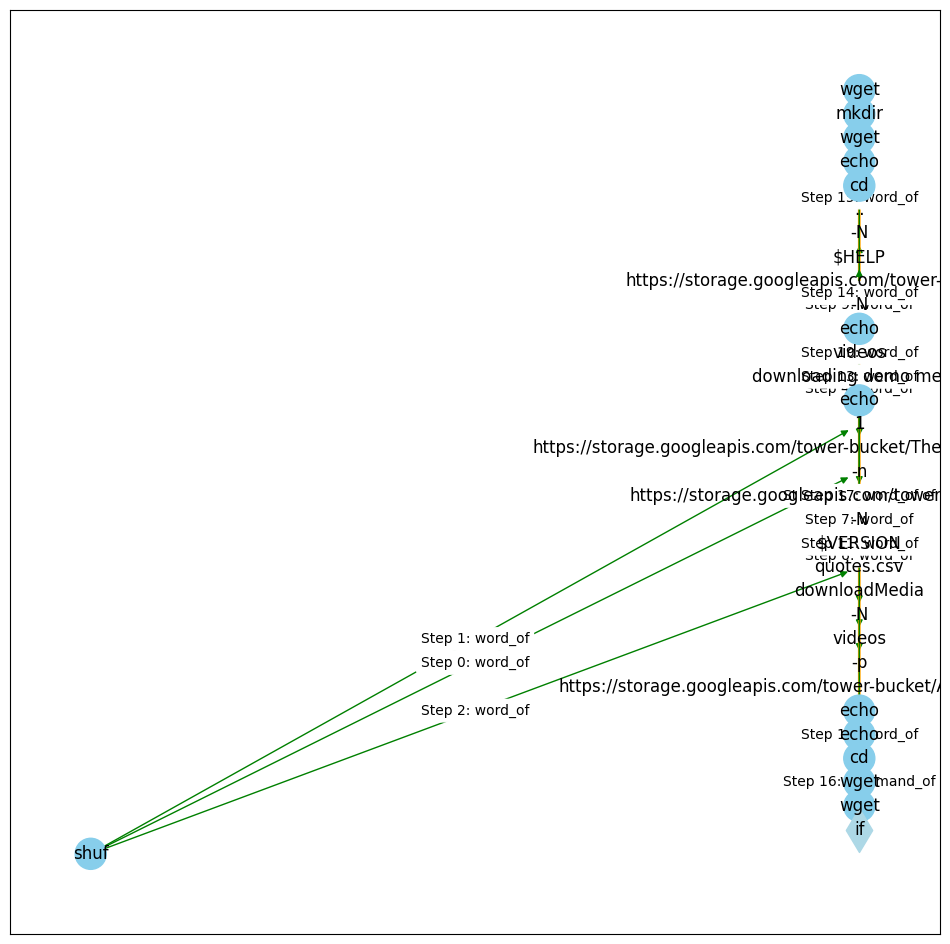

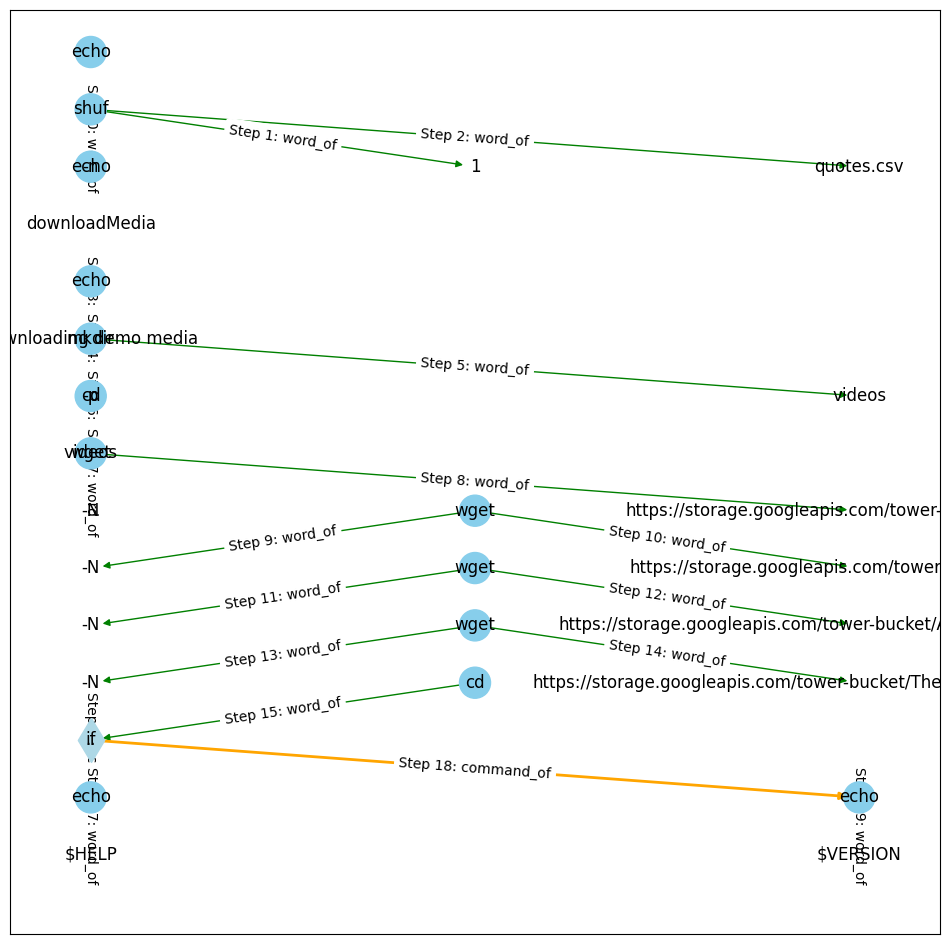

In [16]:
import matplotlib.pyplot as plt

# Call the function with different layouts
plot_networkx_graph(graph, layout='spring')
plot_networkx_graph(graph, layout='circular')
plot_networkx_graph(graph, layout='random')
plot_networkx_graph(graph, layout='shell')
plot_networkx_graph(graph, layout='spectral')
plot_networkx_graph(graph, layout='kamada_kawai')
plot_networkx_graph(graph, layout='planar')
plot_networkx_graph(graph, layout='spiral')
plot_networkx_graph(graph, layout='logical')
plot_networkx_graph(graph, layout='hierarchical')

plt.show()
